We import `netgen.gui` to open the netgen GUI for displaying the ferromagnet. 
We then define the geometry, and draw the box. 
The refinement of the mesh is controlled by `H_MAX` in `ngmesh`.
The maximum time for the simulation is given by `T_MAX`, and has time step `K`.
Use `THETA` to determine "how implicit the tangent plane scheme solver is". Closer to 1/2 is usually better, but must be above 1/2 for unconditional convergence.

In [ ]:
from netgen.csg import *
from ngsolve import *
from ngsolve.utils import (
    Grad
)  # If I don't import these explicitly, VSCode reads them as missing.
import netgen.gui  # this opens up the netgen ui
import Magnetisation_Functions as magfunc
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import Elastic_Functions as elfunc
import General_Functions as genfunc
import sys
np.set_printoptions(threshold=sys.maxsize)

T_MAX_DIM: float = 100e-9  # The maximum time for the simulation in picoseconds
ALPHA: float = 1  # Dissipative constant in the LLG equation.
THETA: float = 0.505  # Should be strictly above 1/2 for unconditional stability
time_step_dim = 1e-10 # seconds
K: float = time_step_dim*genfunc.nondimensional_time(1.761e11, 1.25663706e-6, 217.6)  # TIME STEP
T_MAX: float = T_MAX_DIM*genfunc.nondimensional_time(1.761e11, 1.25663706e-6, 217.6)
KAPPA: float = genfunc.calculate_KAPPA(7874, 3e-9, -1.761e11, 1.25663706e-6)  # Determines the relative strength of the elastic vs. magnetic parts. Uses values for iron here.
#mu, lam = genfunc.lame_parameters(E=2.04e11, v=0.25, KAPPA=KAPPA, mu_0=1.25663706e-6, M_s=217.6)  # determines lame parameters, using iron as a baseline
stress_fac = genfunc.stress_density_factor(KAPPA=KAPPA, mu_0=1.25663706e-6, M_s=217.6)
mu, lam = 54e9/stress_fac, 172e9/stress_fac
lambda_m: float = 1e-6  # saturation magnetostrain parameter
H_MAX: float = 0.4  # Determines how fine the mesh should be.
print(f"µ = {mu}, λ = {lam}, κ = {KAPPA}")
print(f"K = {K}, T_MAX = {T_MAX}")

$\boldsymbol\sigma_{ij} = 2\mu \boldsymbol\varepsilon_{ij}^{\text{el}} + \lambda \delta_{ij}\boldsymbol\varepsilon_{kk}^{\text{el}}$ Hooke's Law

$\mathbb{Z}_{ijkl} \boldsymbol E_{kl} = \frac{3\lambda_{s}}{2}\left(\boldsymbol E_{ij} - \frac{1}{3}\delta_{ij}\boldsymbol E_{kk}\right)$  Isotropic, isochoric magnetostrain for some symmetric input

Here we make a cube with labelled faces.

In [ ]:
def MakeGeometry():  # this makes a box, with labelled faces
    geometry = CSGeometry()
    left = Plane(Pnt(0, 0, 0), Vec(-1, 0, 0)).bc("left")
    right = Plane(Pnt(6, 6, 6), Vec(1, 0, 0)).bc("right")
    front = Plane(Pnt(0, 0, 0), Vec(0, -1, 0)).bc("front")
    back = Plane(Pnt(6, 6, 6), Vec(0, 1, 0)).bc("back")
    bot = Plane(Pnt(0, 0, 0), Vec(0, 0, -1)).bc("bot")
    top = Plane(Pnt(6, 6, 6), Vec(0, 0, 1)).bc("top")

    cube = left * right * front * back * bot * top
    geometry.Add(cube)
    # cube = OrthoBrick(Pnt(0,0,0), Pnt(1,1,1))
    return geometry


ngmesh = MakeGeometry().GenerateMesh(maxh=H_MAX)
# ngmesh.Save("cube.vol")
mesh = Mesh(ngmesh)
Draw(mesh)

We make two FE spaces, one for magnetisation `fes_mag`, and one for displacement/velocity `fes_disp`. (and a legacy FE space for matrices `fes_eps_m`)

The displacement has a `dirichlet` condition, in this case on the `left` face.

We then introduce `f_body`, which is a body force density. We use simply gravity here. You can also set a traction on specific faces with `g_surface`.

In [ ]:
fes_mag = VectorH1(
    mesh, order=1
)  # the finite element space for the magnetisation m_h^i
fes_eps_m = MatrixValued(
    H1(mesh, order=1), dim=3
)  # matrix FE space on the magnetic part
fes_disp = VectorH1(
    mesh, order=1, dirichlet="left"
)  # the finite element space for the displacement u_h^i

print(f"mag_ndof={fes_mag.ndof}, disp_ndof={fes_disp.ndof},\n, dispfree_ndof={fes_disp.FreeDofs()}")
mag_gfu = GridFunction(fes_mag)
disp_gfu = GridFunction(fes_disp)
prev_disp_gfu = GridFunction(fes_disp) #  used to store the previous displacement
zeeman_factor = Parameter(0)
f_zeeman = CoefficientFunction((0, 0, zeeman_factor))
# body force and traction force
body_factor = Parameter(genfunc.force_density_grav(grav_accel=-9.81, density=7874, exchange_length=3e-9, KAPPA=KAPPA, mu_0=1.25663706e-6, M_s=217.6))
body_factor = 0.0
f_body = CoefficientFunction((0.0, 0.0, body_factor))
surface_factor = Parameter(0)
g_surface = CoefficientFunction([(0,surface_factor,0) if bc=="top" else (0,0,0) for bc in mesh.GetBoundaries()])

Here we give initial conditions for the magnetisation and displacement.

The magnetisation can either be given fully random, or uniform magnetisation. If you choose uniform, you must pick the direction. It will be automatically normalised.

The displacement can also be given a fully random or uniform. For the displacement, you can choose the largest magnitude for the random displacement.

In [ ]:
# Initial conditions
mag_gfu = magfunc.give_random_magnetisation(mag_gfu)
#disp_gfu = elfunc.give_random_displacement(disp_gfu)
disp_gfu = elfunc.give_uniform_displacement(disp_gfu, (0.0, 0.0, 0.0))  # initial displacement
velocity_gfu = GridFunction(fes_disp)  # velocity
velocity_gfu = elfunc.give_uniform_displacement(velocity_gfu, (0.0, 0.0, 0.0))  # An initial velocity. Should only be used once in iteration.
Draw(mag_gfu, mesh, "magnetisation")
Draw(disp_gfu, mesh, "displacement")
proj_mag = magfunc.nodal_projection(mag_gfu, fes_mag)
strain_m = magfunc.build_strain_m(proj_mag, lambda_m)
box_vol = Integrate(CoefficientFunction(1.0), mesh, VOL)  # the volume of the mesh, used to normalise the square magnitude integral
current_integral = Integrate(mag_gfu*mag_gfu, mesh, VOL)/box_vol
current_nodal_norm = magfunc.nodal_norm(mag_gfu)
print(f"_/‾|m|^2dx = {current_integral}, nodal sum = {current_nodal_norm} (should both be 1)")

These are lists of values to be used in plotting later, to demonstrate that the `energy` decreases over time. The `integral_list` is a list of true integrals $\int_{\Omega}|\mathbf{m}_{h}^{i}|^2 \mathrm{d}x / \int_{\Omega}\mathrm{d}x$, and the `nodal_sum_list` is a list of the sum of nodal magnitudes $\sum_{z_{k}\in\mathcal{N}_{h}}|\mathbf{m}_{h}^{i}(z_{k})|^2 / \#\mathcal{N}_{h}$. The `nodal_sum_list` should be strictly increasing if the tangent plane scheme is functioning. 

In [ ]:
energy_list = np.array([magfunc.magnetic_energy(mag_gfu, mesh, f_zeeman)]) #  + elfunc.elastic_energy(mesh, disp_gfu, strain_m, f_body, g_surface, KAPPA, mu, lam)
kin_energy_list = np.array([elfunc.initial_kinetic_energy(mesh, velocity_gfu, KAPPA)])
integral_list = np.array([Integrate(mag_gfu*mag_gfu, mesh, VOL)/box_vol])
nodal_sum_list= np.array([magfunc.nodal_norm(mag_gfu)])

In [ ]:
genfunc.export_to_vtk_file(disp_gfu, mag_gfu, mesh, export=True, index=0)

This is the first run of the simulation, which needs to be treated differently as we have a prescribed initial velocity $\dot{\mathbf{u}}^{0}$. First compute the update $\mathbf{v}_{h}^{i}$ to get $\mathbf{m}_{h}^{i+1} = \mathbf{m}_{h}^{i} + \mathbf{v}_{h}^{i}$ using the tangent plane scheme (with GMRES). Then using the conservation of momentum equation calculate $\mathbf{u}_{h}^{i+1}$ using the internal solver of NGSolve.

In [ ]:
num_steps = genfunc.ceiling_division(T_MAX, K)  # This is ceiling division, using upside-down floor division.
#first run

mag_gfu = magfunc.update_magnetisation(fes_mag, mag_gfu, ALPHA, THETA, K, KAPPA, disp_gfu, mu, lam, lambda_m, f_zeeman)

proj_mag = magfunc.nodal_projection(mag_gfu, fes_mag)
strain_m = magfunc.build_strain_m(proj_mag, lambda_m)
new_disp = elfunc.FIRST_RUN_update_displacement(fes_disp, disp_gfu, velocity_gfu, strain_m, f_body, g_surface, K, mu, lam)
prev_disp_gfu.vec.data = disp_gfu.vec.data
disp_gfu.vec.data = new_disp.vec.data

current_integral = Integrate(mag_gfu*mag_gfu, mesh, VOL)/box_vol
current_nodal_norm = magfunc.nodal_norm(mag_gfu)
current_energy = magfunc.magnetic_energy(mag_gfu, mesh, f_zeeman) #+ elfunc.elastic_energy(mesh, disp_gfu, strain_m, f_body, g_surface, KAPPA, mu, lam)
current_kinetic_energy = elfunc.kinetic_energy(mesh, disp_gfu, prev_disp_gfu, KAPPA, K)


integral_list = np.append(integral_list, current_integral)
nodal_sum_list = np.append(nodal_sum_list, current_nodal_norm)
energy_list = np.append(energy_list, current_energy)
kin_energy_list = np.append(kin_energy_list, current_kinetic_energy)

In [ ]:
mip = mesh(0.0, 0.0, 0)
print(strain_m(mip))

In [ ]:
# subsequence runs
for i in range(1, num_steps):  # UPPER BOUND SHOULD BE `num_steps`, TESTING!
    mag_gfu = magfunc.update_magnetisation(fes_mag, mag_gfu, ALPHA, THETA, K, KAPPA, disp_gfu, mu, lam, lambda_m, f_zeeman)
    proj_mag = magfunc.nodal_projection(mag_gfu, fes_mag)
    strain_m = magfunc.build_strain_m(proj_mag, lambda_m)
    new_disp = elfunc.update_displacement(fes_disp, disp_gfu, prev_disp_gfu, strain_m, f_body, g_surface, K, mu, lam)
    prev_disp_gfu.vec.data = disp_gfu.vec.data
    disp_gfu.vec.data = new_disp.vec.data
    #Redraw()
    current_integral = Integrate(mag_gfu*mag_gfu, mesh, VOL)/box_vol
    current_nodal_norm = magfunc.nodal_norm(mag_gfu)
    current_energy = magfunc.magnetic_energy(mag_gfu, mesh, f_zeeman) #+ elfunc.elastic_energy(mesh, disp_gfu, strain_m, f_body, g_surface, KAPPA, mu, lam)
    current_kinetic_energy = elfunc.kinetic_energy(mesh, disp_gfu, prev_disp_gfu, KAPPA, K)
    print(f"Step {i}:_/‾|m|^2dx = {current_integral}, nodal sum = {current_nodal_norm} (should both be 1)\n\
        energy      = {current_energy}")
    print(f"kinetic energy = {current_kinetic_energy}")
    genfunc.export_to_vtk_file(disp_gfu, mag_gfu, mesh, export=True, index=i, save_step=10)
    integral_list = np.append(integral_list, current_integral)
    nodal_sum_list = np.append(nodal_sum_list, current_nodal_norm)
    energy_list = np.append(energy_list, current_energy)
    kin_energy_list = np.append(kin_energy_list, current_kinetic_energy)


Now we plot the `energy_list`, `kin_energy_list` and also the `integral_list`+`nodal_sum_list`.

ValueError: x and y must have same first dimension, but have shapes (1001,) and (570,)

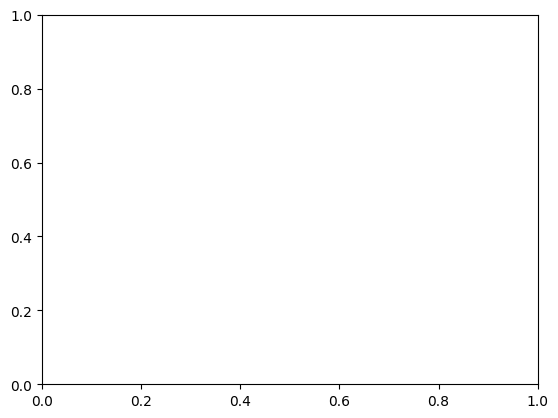

In [45]:
my_time = np.linspace(0, T_MAX_DIM, num_steps+1)

plt.plot(my_time, energy_list, label="Energy")
plt.xlabel("Time")
plt.title(f"dt = {time_step_dim}, total = {T_MAX_DIM}, {num_steps} steps")
plt.legend()
plt.savefig("energy_graph.pdf")
print(energy_list[0])


In [44]:

plt.plot(my_time, kin_energy_list, label="Kin. Energy")
plt.xlabel("Time")
plt.title(f"dt = {time_step_dim}, total = {T_MAX_DIM}, {num_steps} steps")
plt.legend()
plt.savefig("kinetic_graph.pdf")

NameError: name 'my_time' is not defined

In [ ]:
plt.plot(my_time, integral_list, label=r"$\int |\mathbf{m}|^2 \mathrm{d}x$")
plt.plot(my_time, nodal_sum_list, label=r"$\sum |\mathbf{m}(z_k)|^2$")
plt.xlabel(r"time")
plt.legend()
plt.savefig("integral_graph.pdf")

In [ ]:
print(integral_list)